In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 1. 데이터 로드

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
0. view : 집이 얼마나 좋아 보이는지의 정도
1. condition : 집의 전반적인 상태
2. grade : King County grading 시스템 기준으로 매긴 집의 등급
3. sqft_above : 지하실을 제외한 평방 피트
4. sqft_basement : 지하실의 평방 피트
5. yr_built : 집을 지은 년도
6. yr_renovated : 집을 재건축한 년도
7. zipcode : 우편번호
8. lat : 위도
9. long : 경도
0. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
1. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [50]:
train = pd.read_csv("C:\\Users\\32217778\\Downloads\\kaggle-kakr-housing-data\\data\\train.csv")
test = pd.read_csv("C:\\Users\\32217778\\Downloads\\kaggle-kakr-housing-data\\data\\test.csv")
submission = pd.read_csv("C:\\Users\\32217778\\Downloads\\kaggle-kakr-housing-data\\data\\sample_submission.csv")

print(train.shape)
print(test.shape)
print(submission.shape)

(15035, 21)
(6468, 20)
(6468, 2)


In [51]:
# 원본은 따로 보관해놓고 새 df 생성
df = train
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 2. 전처리

할 것:
- date를 int형 데이터로 변환
- id, zipcode 삭제
- yr_renovated, 15년 칼럼 2개, 위도/경도는 보류(일단 삭제 후 모델링)
- 중복, 결측치, 이상치 처리  

### 2-1. date 변환, 칼럼 정리

In [52]:
# date를 int형으로 변환
df['date'] = df['date'].apply(lambda i: i[:6]).astype(int)

# id, zipcode yr_renovated, sqft_living15, sqft_lot15, lat, long 칼럼 삭제
df.drop(columns=['id', 'zipcode', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'lat', 'long'], axis=1, inplace=True)

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963


### 2-2. 중복 데이터

In [53]:
# 중복 데이터 확인
df[df.duplicated()]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
11977,201503,629950.0,3,2.5,1680,1683,2.0,0,0,3,9,1120,560,2014


In [54]:
# 중복된 행 삭제
df.drop_duplicates(inplace=True)

### 2-3. 결측치

In [55]:
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
dtype: int64

결측치는 없다.

### 2-4. 이상치

Boxplot으로 이상치 존재를 대략 확인한다.

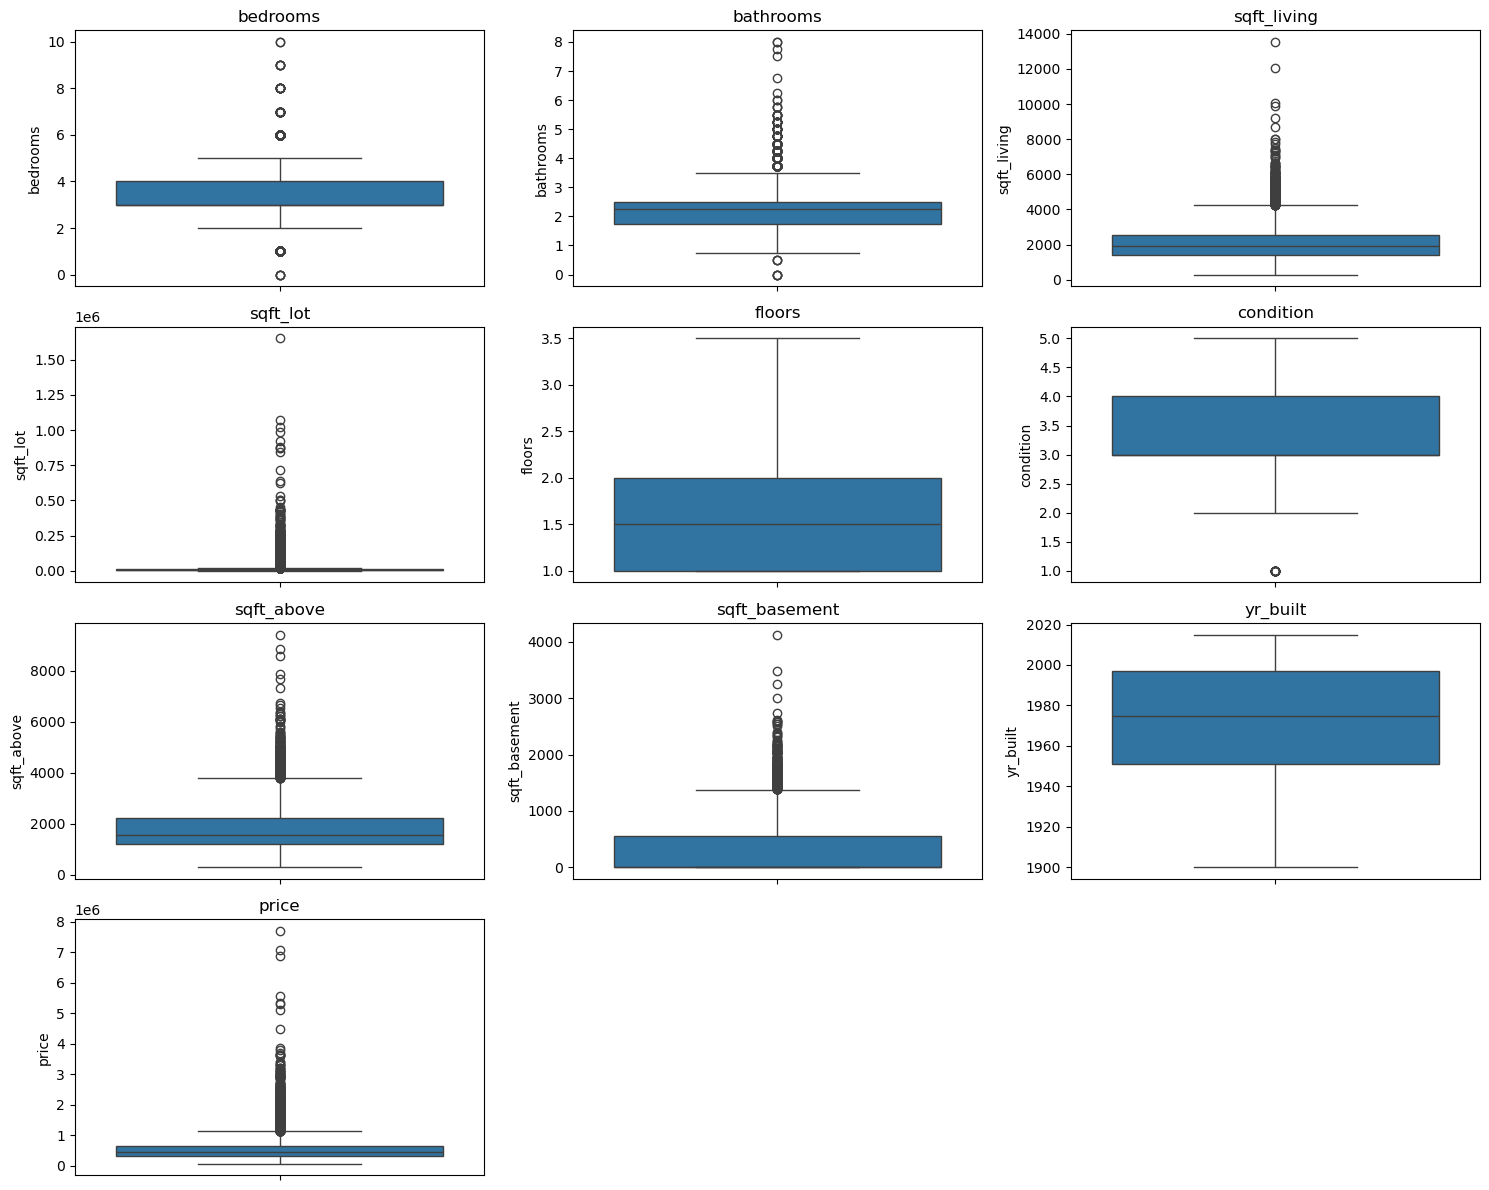

In [ ]:
cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'price']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i])   # 각 subplot에 boxplot
    axes[i].set_title(col)

# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

boxplot을 보니 bedroom, price(target), 면적 변수들이 이상치를 많이 갖는 것을 알 수 있다.  
이번엔 kdeplot으로 보겠다.

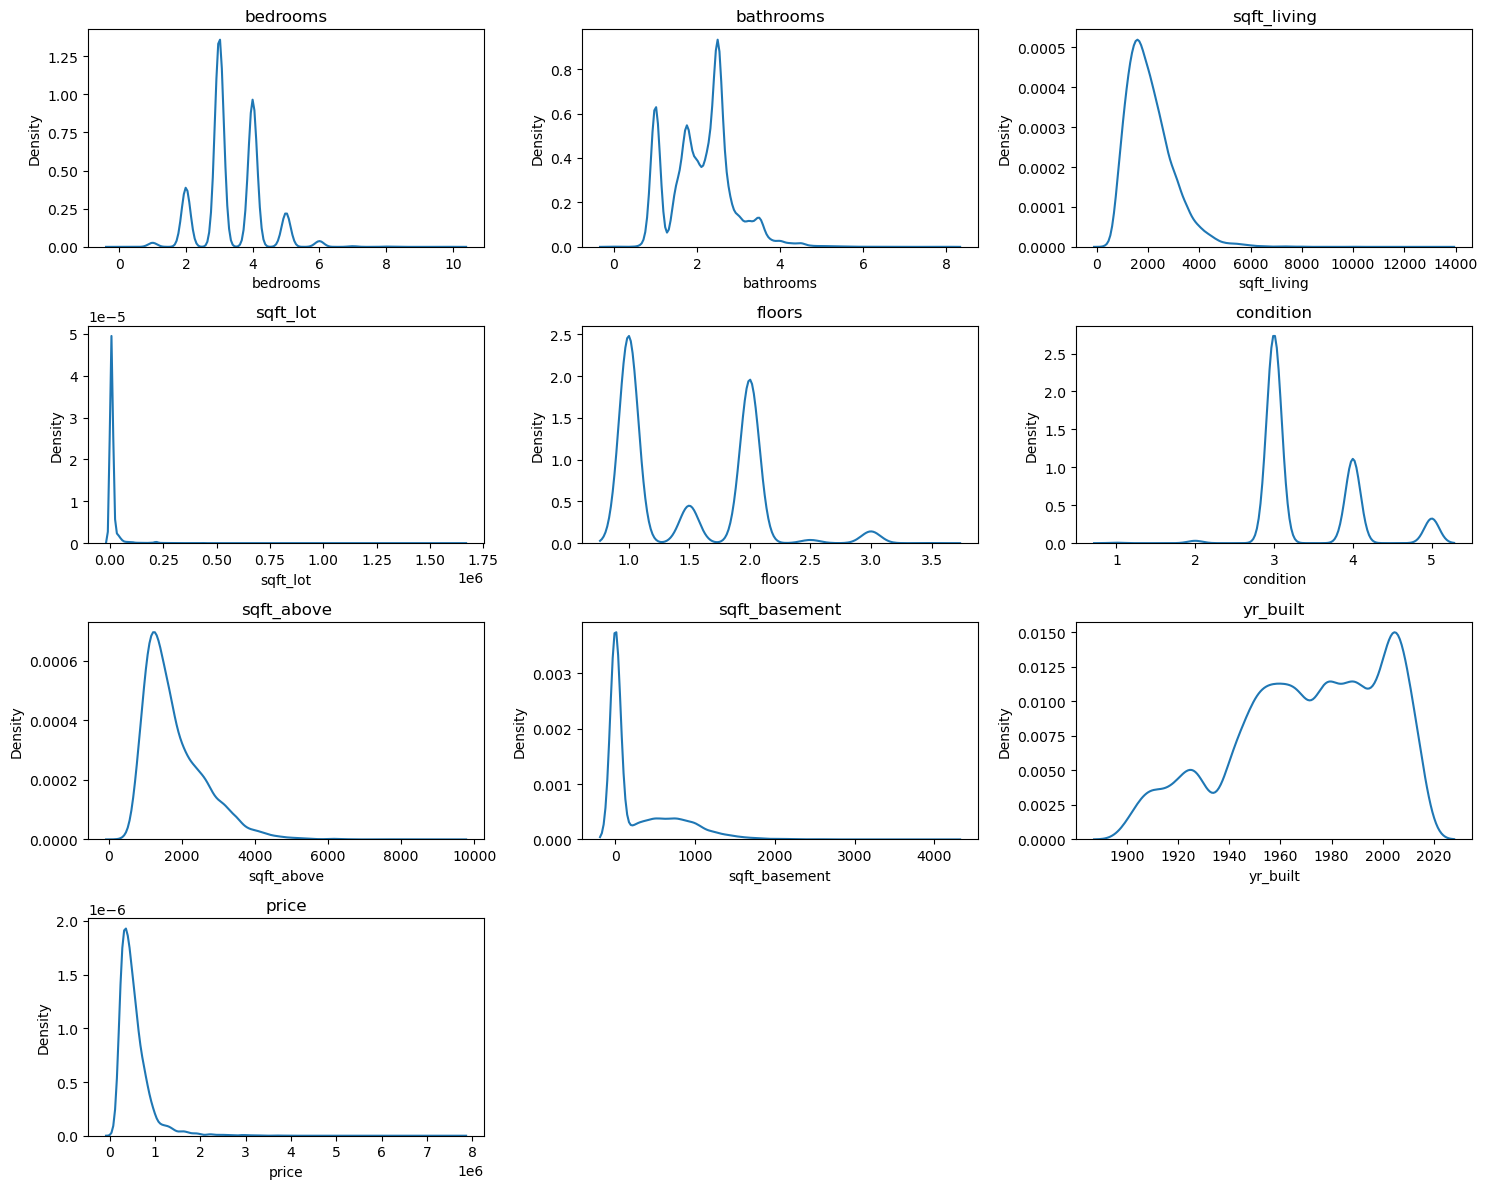

In [57]:
# kdeplot 시각화
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.kdeplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    
# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

왼쪽으로 치우친 price, 면적 칼럼들을 볼 수 있다.  
정규분포의 형태로 만들기 위해 log 변환을 사용해보자.  

하지만 그 전에, 0을 로그변환 하게되면 -inf되는데, 이러면 학습이 불가능하다.  
0의 현황을 먼저 보자.

In [58]:
cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

zero_counts = (df[cols] == 0).sum()
print(zero_counts)

sqft_living         0
sqft_lot            0
sqft_above          0
sqft_basement    9143
dtype: int64


sqft_basement(지하실 면적) 칼럼의 대부분이 0이므로 로그변환을 하지 않겠다.

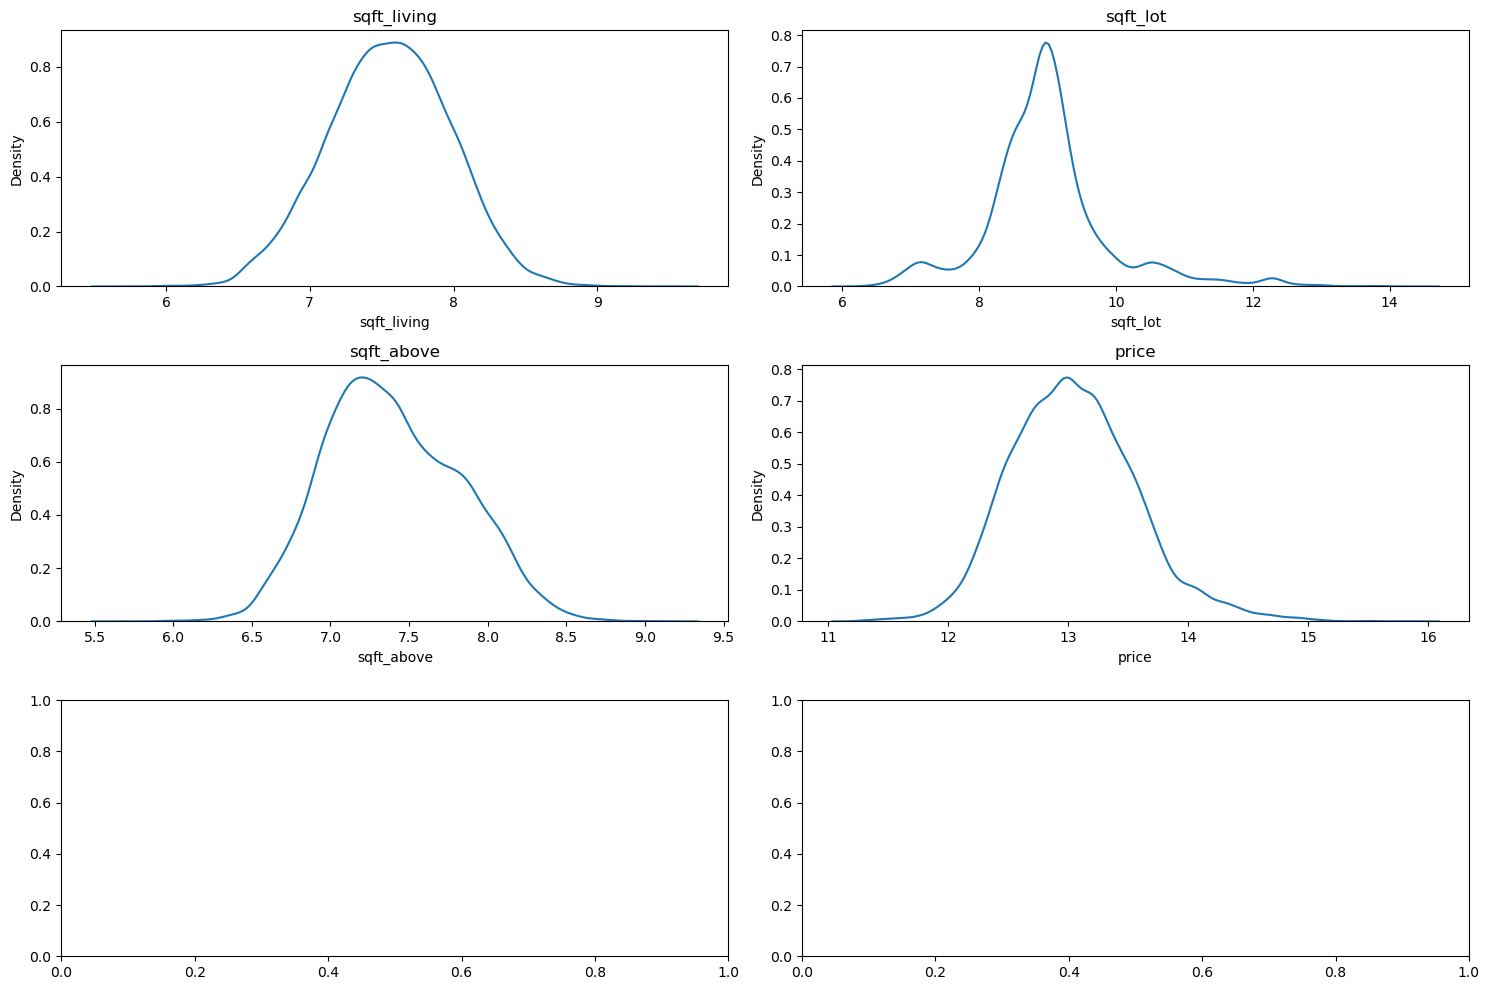

In [59]:
# sqft_basement를 제외하고 로그 변환
outliers = ['sqft_living', 'sqft_lot', 'sqft_above', 'price']
df[outliers] = np.log(df[outliers])

# 다시 시각화
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(outliers):
    sns.kdeplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

이제 어느정도 정규분포의 형태를 띄게 됐다.  
**주의**  
target인 price도 log변환을 했기 때문에 마지막 단계에서 지수변환을 꼭 해줘야 한다.  

이제 마지막으로 y 분리

In [60]:
y = df['price']
del df['price']

test 데이터셋도 똑같이 진행한다.

In [61]:
# date를 int형으로 변환
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# id, zipcode yr_renovated, sqft_living15, sqft_lot15, lat, long 칼럼 삭제
test.drop(columns=['id', 'zipcode', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'lat', 'long'], axis=1, inplace=True)

# 로그 변환
outliers = ['sqft_living', 'sqft_lot', 'sqft_above']
test[outliers] = np.log(test[outliers])

test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,201412,3,2.25,7.851661,8.887653,2.0,0,0,3,7,7.682482,400,1951
1,201412,4,3.00,7.580700,8.517193,1.0,0,0,5,7,6.956545,910,1965
2,201405,4,4.50,8.597851,11.532042,1.0,0,0,3,11,8.266164,1530,2001
3,201504,3,1.00,7.484369,8.918650,1.0,0,0,3,7,6.956545,730,1960
4,201503,3,2.50,7.544332,8.788746,2.0,0,0,3,7,7.544332,0,2003


# 3. 모델링

sklearn의 GridSearchCV를 사용할 것이다.  

GridSearchCV에 입력되는 인자:

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [67]:
# 모델별 하이퍼파라미터
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 7, 10] 
    # 랜덤포레스트는 learning rate가 없음
}

In [ ]:
# 모델 정의
models = {
    'LGBM': (LGBMRegressor(random_state=42, verbose=-1), lgb_param_grid),
    'XGB': (XGBRegressor(random_state=42, verbosity=0), xgb_param_grid),
    'RF': (RandomForestRegressor(random_state=42), rf_param_grid)
}

In [ ]:
test_preds = []

for name, (model, param_grid) in models.items():
    grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
    grid.fit(df, y) 
    
    # test 예측 (로그 변환된 y 기준)
    pred_log = grid.predict(test)
    pred = np.expm1(pred_log)  # 다시 지수 변환
    test_preds.append(pred)

# 평균 앙상블
ensemble_pred = np.mean(test_preds, axis=0)

# 제출용 DataFrame
submission['price'] = ensemble_pred
submission.head()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


,id,price
0,15035,5.339319e+05
1,15036,4.261713e+05
2,15037,1.328986e+06
3,15038,3.236229e+05
4,15039,3.325203e+05
